This notebook is based on the paper "ILDC for CJPE: Indian Legal Documents Corpus for Court Judgment Prediction and Explanation": https://aclanthology.org/2021.acl-long.313.pdf
In this notebook, you would be explaining the judgement prediction by a hierarchical XL-NET model using occulusion and attention methods.

Notebook developed by Vijit Malik and Ashutosh Modi

Regarding any queries, please contact: <vijitvm21@gmail.com> and <ashutoshm.iitk@gmail.com>

In [ ]:
!pip install Sentencepiece

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.3 MB 27.0 MB/s 


In [ ]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.7 MB 4.9 MB/s 
     |████████████████████████████████| 120 kB 69.3 MB/s 
     |████████████████████████████████| 6.6 MB 40.5 MB/s 


In [ ]:
!gdown https://drive.google.com/uc?id=1ZdEzfbKrjf7JxEz7Pi5XdIoEYsyGjS40 

Downloading...
From: https://drive.google.com/uc?id=1ZdEzfbKrjf7JxEz7Pi5XdIoEYsyGjS40
To: /content/playfiles.zip
100% 1.51G/1.51G [00:13<00:00, 111MB/s]


In [ ]:
!unzip playfiles.zip

Archive:  playfiles.zip
   creating: playfiles/
  inflating: __MACOSX/._playfiles    
  inflating: playfiles/.DS_Store     
  inflating: __MACOSX/playfiles/._.DS_Store  
   creating: playfiles/npyfiles/
  inflating: __MACOSX/playfiles/._npyfiles  
   creating: playfiles/model/
  inflating: __MACOSX/playfiles/._model  
  inflating: playfiles/dataset.csv   
  inflating: __MACOSX/playfiles/._dataset.csv  
  inflating: playfiles/npyfiles/XLNet_train.npy  
  inflating: __MACOSX/playfiles/npyfiles/._XLNet_train.npy  
  inflating: playfiles/npyfiles/XLNet_dev.npy  
  inflating: __MACOSX/playfiles/npyfiles/._XLNet_dev.npy  
  inflating: playfiles/npyfiles/XLNet_test.npy  
  inflating: __MACOSX/playfiles/npyfiles/._XLNet_test.npy  
  inflating: playfiles/model/tokenizer_config.json  
  inflating: __MACOSX/playfiles/model/._tokenizer_config.json  
  inflating: playfiles/model/special_tokens_map.json  
  inflating: __MACOSX/playfiles/model/._special_tokens_map.json  
  inflating: playfiles/model/

In [ ]:
!gdown https://drive.google.com/uc?id=1pDMfnXTg1EvwygIXH91NMv0p1MvqLOhd

Downloading...
From: https://drive.google.com/uc?id=1pDMfnXTg1EvwygIXH91NMv0p1MvqLOhd
To: /content/BIGRU_XLNet_Occ.h5
100% 8.59M/8.59M [00:00<00:00, 49.1MB/s]


In [ ]:
!gdown https://drive.google.com/uc?id=14VSMTDe3kcxwh3mK5sRF-SxBI9CPb6gn

Downloading...
From: https://drive.google.com/uc?id=14VSMTDe3kcxwh3mK5sRF-SxBI9CPb6gn
To: /content/BIGRU_XLNet_Att.h5
100% 9.09M/9.09M [00:00<00:00, 101MB/s]


In [ ]:
# Setting up relevant imports needed for running the notebook
import pandas as pd
import numpy as np
from keras import Sequential
from tensorflow.keras.utils import Sequence
from keras.layers import LSTM, Dense, Masking, GRU
import numpy as np
import keras
from keras.utils import np_utils
from keras import optimizers
from keras.models import Sequential, Model
from keras.layers import Embedding, Dense, Input, concatenate, Layer, Lambda, Dropout, Activation
import progressbar
import itertools
from keras.preprocessing.sequence import pad_sequences
import nltk
import datetime
from datetime import datetime
from keras.callbacks import ModelCheckpoint, EarlyStopping, Callback, TensorBoard
import tensorflow as tf
import tensorflow_hub as hub
from keras import initializers as initializers, regularizers, constraints
from keras import backend as K
import numpy as np
from numpy import load
import pandas as pd
import torch
from transformers import XLNetForSequenceClassification, AdamW, XLNetConfig, XLNetTokenizer

#### Setting up some pre-requisite stuff
- Numpy and csv files of datasets. (make sure that the paths are correct)
- Loading datasets and numpy files
- Extracting labels (judgment) for each document
- Writing some utility functions which will be useful later

In [ ]:
##################### Setting up seed and file names (example names currently) ##############
np.random.seed(1337)

embeddingDim = 768
batchSize = 52

gruModelWeightsPath = 'BIGRU_XLNet_Occ.h5'
bigruAttentionModelWeightsPath = 'BIGRU_XLNet_Att.h5'
xlnetModelWeightsPath = 'playfiles/model/'

ildcDatasetCsvPath = 'playfiles/dataset.csv'

trainDatasetEmbeddingsFromXlnetPath = 'playfiles/npyfiles/XLNet_train.npy'
validationDatasetEmbeddingsFromXlnetPath = 'playfiles/npyfiles/XLNet_dev.npy'
testDatasetEmbeddingsFromXlnetPath = 'playfiles/npyfiles/XLNet_test.npy'

saveOcclusionWeightsPath = "occwts.npy"

In [ ]:
ildcDataset = pd.read_csv(ildcDatasetCsvPath)
trainDatasetEmbeddingsFromXlnet = load(trainDatasetEmbeddingsFromXlnetPath, allow_pickle = True)
validationDatasetEmbeddingsFromXlnet = load(validationDatasetEmbeddingsFromXlnetPath, allow_pickle= True)
testDatasetEmbeddingsFromXlnet = load(testDatasetEmbeddingsFromXlnetPath, allow_pickle= True)

In [ ]:
#################### Utility Functions #########################


####### Function to extract labels for each input from the dataframe
def getLabelsFromDataframe(df):
    return df['label'].to_list()


####### Function to determine number of graphs needed to plotted
def numberOfGraphsToBeMade(l_scores):
    g_to_be = 0
    for i in range(25):
        found = False
        for chunks in l_scores:
            if(len(chunks) == i+1):
                found=True
        
        if(found):
            g_to_be+=1
    return g_to_be

In [ ]:
validationIldcDataset = ildcDataset.loc[ildcDataset['split'] == 'dev']
trainIldcDataset = ildcDataset.loc[ildcDataset['split'] == 'train']
testIldcDataset = ildcDataset.loc[ildcDataset['split'] == 'test']

trainLabels = getLabelsFromDataframe(trainIldcDataset)
validationLabels = getLabelsFromDataframe(validationIldcDataset)
testLabels = getLabelsFromDataframe(testIldcDataset)



```
# This is formatted as code
```

#### Setting up the BiGRU model with the saved weights (trained on ILDC multi train set)

In [ ]:
from keras import layers
# Input layer to convert into required tensor shape
text_input = Input(shape=(None,768,), dtype='float32', name='text')
# Masking layer to mask the padded values
l_mask = layers.Masking(mask_value=-99.)(text_input)
# After masking we encoded the vector using 2 bidirectional GRU's
encoded_text = layers.Bidirectional(GRU(100,return_sequences=True))(l_mask)
encoded_text1 = layers.Bidirectional(GRU(100,))(encoded_text)
# Added a dense layer after encoding
out_dense = layers.Dense(30, activation='relu')(encoded_text1)
# And we add a sigmoid classifier on top
out = layers.Dense(1, activation='sigmoid')(out_dense)
# At model instantiation, we specify the input and the output:
model = Model(text_input, out)
model.compile(optimizer='Adam',
              loss='binary_crossentropy',
              metrics=['acc'])
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text (InputLayer)           [(None, None, 768)]       0         
                                                                 
 masking_1 (Masking)         (None, None, 768)         0         
                                                                 
 bidirectional_2 (Bidirectio  (None, None, 200)        522000    
 nal)                                                            
                                                                 
 bidirectional_3 (Bidirectio  (None, 200)              181200    
 nal)                                                            
                                                                 
 dense_2 (Dense)             (None, 30)                6030      
                                                                 
 dense_3 (Dense)             (None, 1)                 31  

In [ ]:
model.load_weights(gruModelWeightsPath)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

In [ ]:
#### Building the occluded embeddings

In [ ]:
testOccludedEmbeddings = []
testCorrespondingLabels = []

for i in range(len(testDatasetEmbeddingsFromXlnet)):
    actualEmbeddings = testDatasetEmbeddingsFromXlnet[i]
    actualLabel = testLabels[i]
    testOccludedEmbeddings.append(actualEmbeddings)
    testCorrespondingLabels.append(actualLabel)
    for j in range(len(actualEmbeddings)):
        occludedEmbeddings = []
        for k in range(len(actualEmbeddings)):
            if(k == j):
                occludedEmbeddings.append(np.zeros(embeddingDim))
            else:
                occludedEmbeddings.append(actualEmbeddings[k])
                
        testOccludedEmbeddings.append(np.array(occludedEmbeddings))
        testCorrespondingLabels.append(actualLabel)

In [ ]:
print("The number of occluded embeddings is {:}, and their corresponding number of labels is {:}".
      format(len(testOccludedEmbeddings), len(testCorrespondingLabels)))

The number of occluded embeddings is 19504, and their corresponding number of labels is 19504


In [ ]:
print("Printing a couple of lengths of occluded embeddings for sanity: ")
print(len(testOccludedEmbeddings[0]),
      len(testOccludedEmbeddings[1]),
      len(testOccludedEmbeddings[2]),
      len(testOccludedEmbeddings[3]),
      len(testOccludedEmbeddings[10]))

Printing a couple of lengths of occluded embeddings for sanity: 
8 8 8 8 5


In [ ]:
#### Extracting the predictions of occluded (and normal embeddings) chunk embeddings from the BiGRU

In [ ]:
num_features = embeddingDim

def new_test_generator():
    x_list = testOccludedEmbeddings
    y_list = testCorrespondingLabels
    print(len(x_list), len(y_list))
    # Generate batches
    while True:
      for b in range(batches_per_epoch_test):
        longest_index = (b + 1) * batchSize - 1
        timesteps = len(max(testOccludedEmbeddings[:(b + 1) * batchSize][-batchSize:], key=len))
        x_train = np.full((batchSize, timesteps, num_features), -99.)
        y_train = np.zeros((batchSize,  1))
        for i in range(batchSize):
            li = b * batchSize + i
            if li >= len(x_list):
                break
            # print(x_train[i].shape, len(x_list[li]))
            x_train[i, 0:len(x_list[li]), :] = x_list[li]
            y_train[i] = y_list[li]
        yield x_train, y_train

In [ ]:
########## Getting the predictions on test dataset ######################

num_sequences_test = len(testOccludedEmbeddings)
print(num_sequences_test)

print("Number of sequences in test dataset is: {:}".format(num_sequences_test))

if(num_sequences_test%batchSize == 0):
  batches_per_epoch_test = int(num_sequences_test/batchSize)
else:
  batches_per_epoch_test = int(num_sequences_test/batchSize) + 1
num_features = embeddingDim
model.evaluate_generator(new_test_generator(), steps= batches_per_epoch_test)
predictionsTestDataset = model.predict_generator(new_test_generator(), steps= batches_per_epoch_test)

print("Total number of predictions is: {:}".format(len(predictionsTestDataset)))

19504
Number of sequences in test dataset is: 19504
19504 19504


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  del sys.path[0]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  


19504 19504
Total number of predictions is: 19552


In [ ]:
#### Calculating occlusion scores for each chunk in each document of the test dataset

In [ ]:
occlusionScoresForTestDataset = []

startPointer = 0
for i in range(len(testDatasetEmbeddingsFromXlnet)):
    numberOfEmbeddingsForThisDocument = testDatasetEmbeddingsFromXlnet[i].shape[0]
    numberOfEmbeddingsForThisDocument += 1 # Adding 1 since there is a normal list of embeddings and occluded embeddings
    predictionForThisDocument = predictionsTestDataset[startPointer] > 0.5
    
    chunkScoresForThisDocument = []
    for j in range(numberOfEmbeddingsForThisDocument - 1):
        if(predictionForThisDocument):
            chunkScoresForThisDocument.append(-1*(predictionsTestDataset[startPointer + j + 1]
                                                 -predictionsTestDataset[startPointer]))
        else:
            chunkScoresForThisDocument.append(predictionsTestDataset[startPointer + j + 1]
                                             - predictionsTestDataset[startPointer])
            
    occlusionScoresForTestDataset.append(chunkScoresForThisDocument)
    startPointer += numberOfEmbeddingsForThisDocument

print("/n")    
print("Number of scores list is {:} (should be equal to the number of documents in test set which is {:})".
      format(len(occlusionScoresForTestDataset), len(testDatasetEmbeddingsFromXlnet)))

actualOcclusionScoresForTestDataset = []
for scores in occlusionScoresForTestDataset:
  dummyList =[]
  for lst in scores:
    dummyList.append(lst[0])

  actualOcclusionScoresForTestDataset.append(dummyList)

print("/n")
print("Actual Occlusion Scores for first document are {:}".
      format(actualOcclusionScoresForTestDataset[0]))

/n
Number of scores list is 1517 (should be equal to the number of documents in test set which is 1517)
/n
Actual Occlusion Scores for first document are [0.013133168, -0.0013899207, 0.00028181076, 0.019263506, 0.0034130216, 0.0047912, 0.022851229, 0.13889748]


#### Visualizing scores of ILDC whole test dataset (1517 documents only)

Note that since there are 1517 documents in the test set. We are visualizing it with respect to averaging out the occlusion scores of all the documents having same number of chunks. To put it as an example. If out of these 1517 documents, we were having 1000 documents with 5 chunks each and 517 documents with 8 chunks each, we would be having two graphs:

- For 1000 documents whose scores are averaged for each chunk in all 1000 documents
- For 517 documents whose scores are averaged for each chunk in all 517 documents

In [ ]:
actualPredictionsForTestDataset = []

startPointer = 0
for i in range(len(testDatasetEmbeddingsFromXlnet)):
    numberOfEmbeddingsForThisDocument = testDatasetEmbeddingsFromXlnet[i].shape[0]
    numberOfEmbeddingsForThisDocument += 1 # Adding 1 since there is a normal list of embeddings and occluded embeddings
    predictionForThisDocument = predictionsTestDataset[startPointer] > 0.5
    actualPredictionsForTestDataset.append(predictionForThisDocument)
    startPointer += numberOfEmbeddingsForThisDocument
    
print("Lets see the predictions for each document and whether its correct or not\n")
for i in range(len(actualPredictionsForTestDataset)):
    print("Document number: {:} trueLabel = {:}, predictedLabel = {:}, isCorrect = {:}".
          format(i+1, testLabels[i], actualPredictionsForTestDataset[i], 
                 testLabels[i] == actualPredictionsForTestDataset[i]))

Lets see the predictions for each document and whether its correct or not

Document number: 1 trueLabel = 1, predictedLabel = [ True], isCorrect = [ True]
Document number: 2 trueLabel = 0, predictedLabel = [False], isCorrect = [ True]
Document number: 3 trueLabel = 0, predictedLabel = [ True], isCorrect = [False]
Document number: 4 trueLabel = 0, predictedLabel = [ True], isCorrect = [False]
Document number: 5 trueLabel = 1, predictedLabel = [ True], isCorrect = [ True]
Document number: 6 trueLabel = 0, predictedLabel = [False], isCorrect = [ True]
Document number: 7 trueLabel = 0, predictedLabel = [False], isCorrect = [ True]
Document number: 8 trueLabel = 0, predictedLabel = [False], isCorrect = [ True]
Document number: 9 trueLabel = 1, predictedLabel = [False], isCorrect = [False]
Document number: 10 trueLabel = 0, predictedLabel = [False], isCorrect = [ True]
Document number: 11 trueLabel = 1, predictedLabel = [ True], isCorrect = [ True]
Document number: 12 trueLabel = 0, predicte

In [ ]:
print("Number of graphs that need to be generated are: {:}".
      format(numberOfGraphsToBeMade(actualOcclusionScoresForTestDataset)))

Number of graphs that need to be generated are: 25


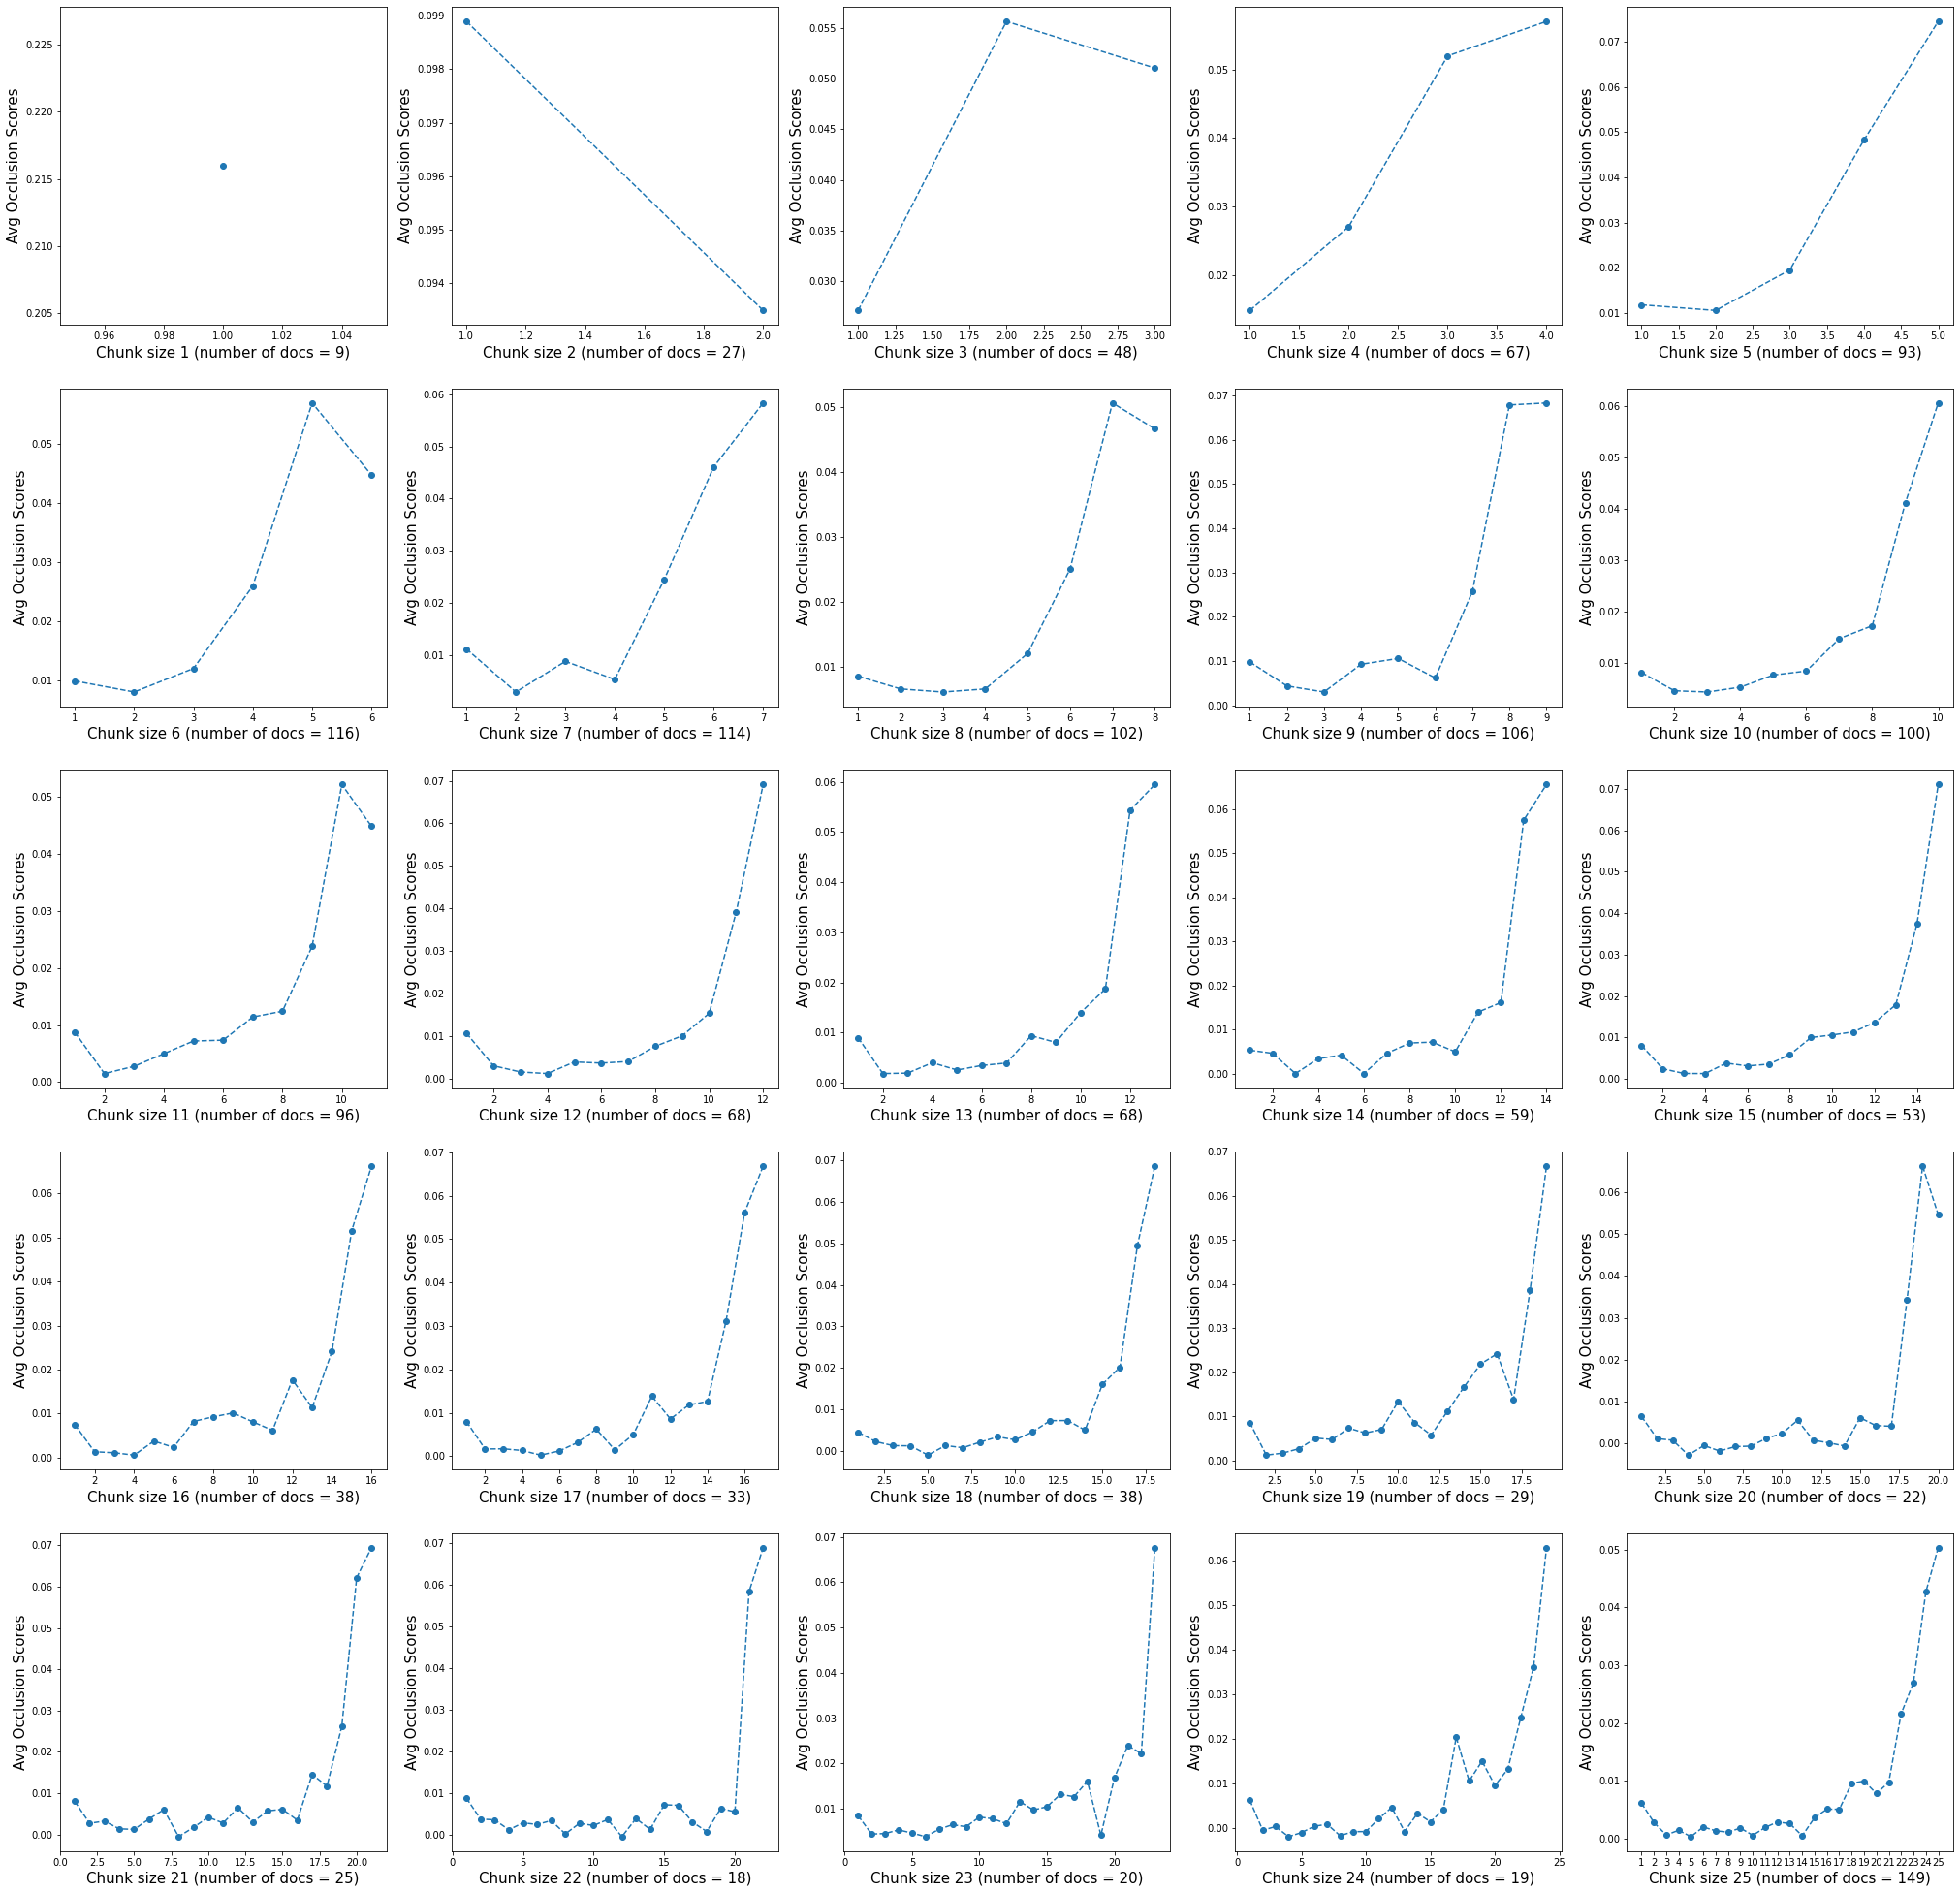

In [ ]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(5, 5, figsize=(35, 35))
l=0
r=0

for i in range(25):
  foundAtLeastOneDocument = False
  documentsWithSameLengthChunks = []

  for chunk in actualOcclusionScoresForTestDataset:
    if(len(chunk) == i+1):
      foundAtLeastOneDocument=True
      documentsWithSameLengthChunks.append(chunk)

  if(foundAtLeastOneDocument):
    meanScoresOfChunksAcrossDocuments = np.mean(documentsWithSameLengthChunks, axis=0)
    plt.xticks(list(range(1,len(meanScoresOfChunksAcrossDocuments)+1,1)))
    y = list(range(1,len(meanScoresOfChunksAcrossDocuments)+1,1))
    axs[l,r].plot(y, meanScoresOfChunksAcrossDocuments, marker='o', linestyle='dashed')
    xlabel_str = 'Chunk size ' + str(len(meanScoresOfChunksAcrossDocuments)) + " (number of docs = " + str(len(documentsWithSameLengthChunks)) + ")"
    axs[l,r].set_xlabel(xlabel_str,fontsize = 15.0)
    axs[l,r].set_ylabel('Avg Occlusion Scores',fontsize = 15.0)
    r+=1
    if(r==5):
      l+=1
      r=0

In [ ]:
np.save(saveOcclusionWeightsPath, actualOcclusionScoresForTestDataset)

/usr/local/lib/python3.7/dist-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


#### Setting up the BiGRU with Attention Model

1.   Setting up the model structure
2.   Loading a trained model



In [ ]:
def dot_product(x, kernel):
    """
    Wrapper for dot product operation, in order to be compatible with both
    Theano and Tensorflow
    Args:
        x (): input
        kernel (): weights
    Returns:
    """
    if K.backend() == 'tensorflow':
        return K.squeeze(K.dot(x, K.expand_dims(kernel)), axis=-1)
    else:
        return K.dot(x, kernel)

class AttentionLayer(Layer):
    """
    Hierarchial Attention Layer as described by Hierarchical Attention Networks for Document Classification(2016)
    - Yang et. al.
    Source: https://www.cs.cmu.edu/~hovy/papers/16HLT-hierarchical-attention-networks.pdf
    Theano backend
    """
    def __init__(self,attention_dim=200,return_coefficients=False,**kwargs):
        # Initializer 
        self.supports_masking = True
        self.return_coefficients = return_coefficients
        self.init = initializers.get('glorot_uniform') # initializes values with uniform distribution
        self.attention_dim = attention_dim
        super(AttentionLayer, self).__init__(**kwargs)

    def get_config(self):
        config = super().get_config().copy()
        config.update({
        'attention_dim': self.attention_dim,
        'return_coefficients': self.return_coefficients,
        })
        return config

    def build(self, input_shape):
        # Builds all weights
        # W = Weight matrix, b = bias vector, u = context vector
        assert len(input_shape) == 3
        self.W = K.variable(self.init((input_shape[-1], self.attention_dim)),name='W')
        self.b = K.variable(self.init((self.attention_dim, )),name='b')
        self.u = K.variable(self.init((self.attention_dim, 1)),name='u')
        self._trainable_weights = [self.W, self.b, self.u]

        super(AttentionLayer, self).build(input_shape)

    def compute_mask(self, input, input_mask=None):
        return None

    def _get_attention_weights(self, X):
        
        u_tw = K.tanh(K.dot(X, self.W))
        tw_stimulus = K.dot(u_tw, self.u)

        # Remove the last axis an apply softmax to the stimulus to
        # get a probability.
        tw_stimulus = K.squeeze(tw_stimulus, -1)
        tw_stimulus = K.exp(tw_stimulus)
        

        tw_stimulus /= K.cast(K.sum(tw_stimulus, axis=1, keepdims=True) + K.epsilon(), K.floatx())
        att_weights = K.expand_dims(tw_stimulus)
        return att_weights

    def call(self, hit, mask=None):
        att_weights = self._get_attention_weights(hit)
  
        uit = K.bias_add(K.dot(hit, self.W),self.b)
        uit = K.tanh(uit)
        
        ait = K.dot(uit, self.u)
        ait = K.squeeze(ait, -1)
        ait = K.exp(ait)
        
        if mask is not None:
            ait *= K.cast(mask, K.floatx())

        ait /= K.cast(K.sum(ait, axis=1, keepdims=True) + K.epsilon(), K.floatx())
        ait = K.expand_dims(ait)
        weighted_input = hit * ait
        
        if self.return_coefficients:
            return [K.sum(weighted_input, axis=1), ait]
        else:
            return K.sum(weighted_input, axis=1)

    def compute_output_shape(self, input_shape):
        
        if self.return_coefficients:
            return [(input_shape[0], input_shape[-1]), (input_shape[0], input_shape[-1], 1)]
        else:
            return input_shape[0], input_shape[-1]

In [ ]:
from keras import initializers as initializers, regularizers, constraints
from keras import backend as K
from keras import layers
from tensorflow import keras
from sklearn.metrics import accuracy_score
# Input layer to convert into required tensor shape
text_input = Input(shape=(None,768,), dtype='float32', name='text')
# Masking layer to mask the padded values
l_mask = layers.Masking(mask_value=-99.)(text_input) #2 sent_encoder
# After masking we encoded the vector using 2 bidirectional GRU's
encoded_text = layers.Bidirectional(GRU(100,return_sequences=True))(l_mask) 
encoded_text1 = layers.Bidirectional(GRU(100,return_sequences=True))(encoded_text)
# Then we add the Attention Layer which we created above
sent_att,sent_coeffs, = AttentionLayer(200,return_coefficients=True,name='sent_attention')(encoded_text1)
# Add a dropout layer 
sent_drop = Dropout(0.5,name='sent_dropout')(sent_att)
# Added a dense layer after encoding
out1 = layers.Dense(30, activation='relu')(sent_drop) 
# And we add a sigmoid classifier on top
out = layers.Dense(1, activation='sigmoid')(out1)
model = Model(text_input,out)

model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text (InputLayer)           [(None, None, 768)]       0         
                                                                 
 masking_2 (Masking)         (None, None, 768)         0         
                                                                 
 bidirectional_4 (Bidirectio  (None, None, 200)        522000    
 nal)                                                            
                                                                 
 bidirectional_5 (Bidirectio  (None, None, 200)        181200    
 nal)                                                            
                                                                 
 sent_attention (AttentionLa  [(None, 200),            40400     
 yer)                         (None, None, 1)]                   
                                                           

In [ ]:
model.load_weights(bigruAttentionModelWeightsPath)
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['acc'])

In [ ]:
# getting the self attention layer from the trained model and creating a new model with that layer to get attention weights
att_layer = model.get_layer('sent_attention')
prev_tensor = att_layer.input

dummy_layer = Lambda(lambda x: att_layer._get_attention_weights(x))(prev_tensor)
model2 = Model(text_input, dummy_layer)
model2.summary()

The following Variables were used a Lambda layer's call (lambda), but
are not present in its tracked objects:
  <tf.Variable 'sent_attention/W:0' shape=(200, 200) dtype=float32>
  <tf.Variable 'sent_attention/u:0' shape=(200, 1) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.


Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text (InputLayer)           [(None, None, 768)]       0         
                                                                 
 masking_2 (Masking)         (None, None, 768)         0         
                                                                 
 bidirectional_4 (Bidirectio  (None, None, 200)        522000    
 nal)                                                            
                                                                 
 bidirectional_5 (Bidirectio  (None, None, 200)        181200    
 nal)                                                            
                                                                 
 lambda (Lambda)             (None, None, 1)           0         
                                                                 
Total params: 703,200
Trainable params: 703,200
Non-trainab

In [ ]:
# splitting test data depending on chunk length
x_chunks = []*25
for i in range(25):
  x_chunks.append([])
for i in range(len(testDatasetEmbeddingsFromXlnet)):
  x_chunks[len(testDatasetEmbeddingsFromXlnet[i]) - 1].append(testDatasetEmbeddingsFromXlnet[i])

#### Getting the Attention scores for each chunk and visualizing them for the ILDC test dataset. The average chunk score calculated in similar fashion as done in Occlusion section.

In [ ]:
# getting attention weights for each chunk and finding the mean over all data for a particular chunk length
wt_vector = []*25
wt_total = []*25

for chunk_length in range(25):
  wt_vector.append([])
  wt_total.append(0)
  for i in range(len(x_chunks[chunk_length])):
     curr = x_chunks[chunk_length][i]
     curr = curr.reshape((1, len(curr), 768))
     wt_vector[chunk_length].append(model2.predict(curr))
     wt_total[chunk_length] +=wt_vector[chunk_length][i]
  wt_total[chunk_length] /= len(wt_vector[chunk_length])
  wt_total[chunk_length] = np.squeeze(wt_total[chunk_length], axis = 0)
  wt_total[chunk_length] = np.squeeze(wt_total[chunk_length], axis = 1)

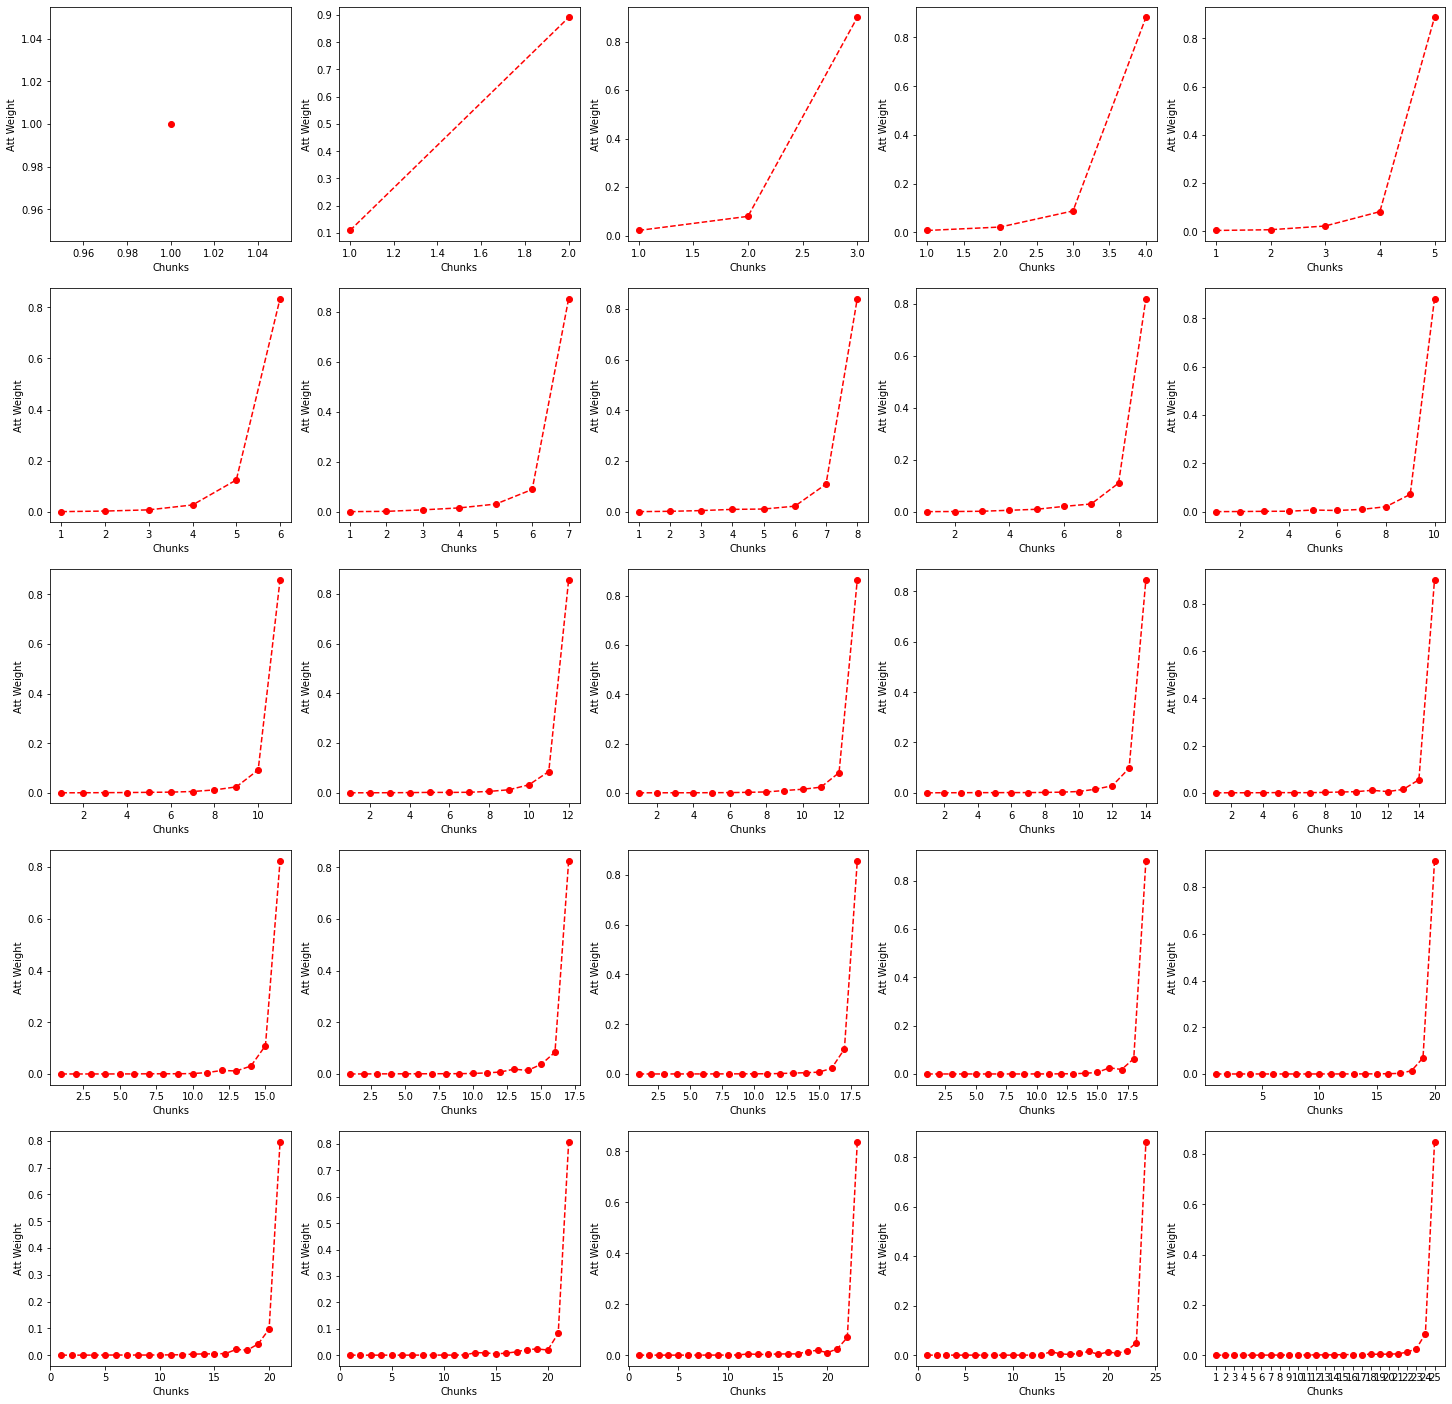

In [ ]:
# plotting subplots for each chunk length( x axis: chunk size, y axis: mean attention weight)
import matplotlib.pyplot as plt

fig, axs = plt.subplots(5, 5, figsize=(25, 25))
num = [1]

for chunk_len in range(25):
  y = num
  plt.xticks(y)
  axs[(int)(chunk_len/5), chunk_len%5].plot(y, wt_total[chunk_len], marker = 'o', linestyle = 'dashed', color='r')
  num.append(chunk_len + 2)

for ax in axs.flat:
    ax.set(xlabel='Chunks', ylabel='Att Weight')
plt.show()

#### Using Occlusion at XLNet Level now
Loading the XLNet saved model (trained on CJPE train data)

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_dir = xlnetModelWeightsPath
tokenizer = XLNetTokenizer.from_pretrained(model_dir)
model = XLNetForSequenceClassification.from_pretrained(model_dir, output_hidden_states=True)
model.to(device)

XLNetForSequenceClassification(
  (transformer): XLNetModel(
    (word_embedding): Embedding(32000, 768)
    (layer): ModuleList(
      (0): XLNetLayer(
        (rel_attn): XLNetRelativeAttention(
          (layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (ff): XLNetFeedForward(
          (layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (layer_1): Linear(in_features=768, out_features=3072, bias=True)
          (layer_2): Linear(in_features=3072, out_features=768, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
          (activation_function): GELUActivation()
        )
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (1): XLNetLayer(
        (rel_attn): XLNetRelativeAttention(
          (layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (ff): XLNetFeedForward

#### Loading NLTK
Loading nltk for sentences level tokenization. Each sentence's score would then be determined using occlusion

In [ ]:
nltk.download('punkt')
nltk_tokenizer = nltk.data.load('tokenizers/punkt/english.pickle')
df = pd.read_csv(ildcDatasetCsvPath)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


#### Loading Chunk Occlusion Scores

In [ ]:
chunk_scores = load(saveOcclusionWeightsPath, allow_pickle = True)
chunk_scores = list(chunk_scores)

#### Utility functions for Occlusion over XLNet

In [ ]:
def xlnet_tokenize(sents, tokenizer):
  tok_sents = []
  for sen in sents:
    tok_sents.append(tokenizer.tokenize(sen))

  return tok_sents




def sentence_marker(tokenized_sents):
  marker_array = []
  sent_num=1
  for tokenized_sentence in tokenized_sents:
    sentence_marker = []
    for i in range(len(tokenized_sentence)):
      if(i==0):
        sentence_marker.append(sent_num)
      else:
        sentence_marker.append(0)

    sent_num+=1
    marker_array.append(sentence_marker)

  return marker_array




def chunked_tokens_maker(all_toks, markers):
  splitted_toks = []
  splitted_markers = []
  l=0
  r=510
  while(l<len(all_toks)):
    splitted_toks.append(all_toks[l:min(r,len(all_toks))])
    splitted_markers.append(markers[l:min(r,len(markers))])
    l+=410
    r+=410

  return splitted_toks, splitted_markers




def calculate_num_of_sents(chunk_marker_list):
  ct=0
  for i in range(len(chunk_marker_list)):
    if(chunk_marker_list[i] != 0):
      ct+=1
  
  return ct-1



def sentence_tokens_maker(marks, chunk_toks):
  pair_of_ids = []
  st = -1000
  ed = -1000
  for i,mark in enumerate(marks):
    if(mark==-777):
      st=i
    
    if(mark!=-777 and mark!=777 and mark!=0):
      ed=i-1
      pair_of_ids.append((st,ed))
      st=i

    if(mark==777):
      ed=i
      pair_of_ids.append((st,ed))

  return pair_of_ids




def att_masking(input_ids):
  attention_masks = []
  for sent in input_ids:
    att_mask = [int(token_id > 0) for token_id in sent]
    attention_masks.append(att_mask)
  return attention_masks



def get_output_for_one_vec(input_id, att_mask):
  input_ids = torch.tensor(input_id)
  att_masks = torch.tensor(att_mask)
  input_ids = input_ids.unsqueeze(0)
  att_masks = att_masks.unsqueeze(0)
  model.eval()
  input_ids = input_ids.to(device)
  att_masks = att_masks.to(device)
  with torch.no_grad():
      logits = model(input_ids=input_ids, token_type_ids=None, attention_mask=att_masks).logits
      encoded_layers = model(input_ids=input_ids, token_type_ids=None, attention_mask=att_masks).hidden_states

  return logits




def get_XLNet_output_logits(encoded_sents, tokenizer, model):
  e_sents = []
  e_sents.append(encoded_sents)
  e_sents = pad_sequences(e_sents, maxlen=512, value=0, dtype="long", padding="pre")
  att_masks = att_masking(e_sents)
  return get_output_for_one_vec(e_sents[0], att_masks[0])


def xlnet_detok(xtoks):
  xtoks[0] = "_" + xtoks[0]
  words = []
  word = ""
  for tok in xtoks:
    if(tok[0] == "▁"):
      words.append(word)
      word = tok[1:]
    else:
      word+=tok

  output = ""
  for word in words[1:]:
    output += (word + " ")

  return output

In [ ]:
def get_explanation(chunked_xlnet_tokens, chunked_markers, chunk_scores, doc_num, tokenizer, predicted_label):
    explanation = ""
    for chunk_number,score in enumerate(chunk_scores[doc_num]):
        if(chunk_number == 0):
          chunked_markers[chunk_number][0] = -777
          chunked_markers[chunk_number][-1] = 777
        else:
          if(len(chunked_markers[chunk_number]) < 101):
            continue
          chunked_markers[chunk_number][100] = -777
          chunked_markers[chunk_number][-1] = 777

        if(score < 0):
          continue

        ct_sent = calculate_num_of_sents(chunked_markers[chunk_number])
        #print("ct_sent: {:}".format(ct_sent))
        top_k = 0.4*ct_sent
        dict_sent_to_score = {}
        #print(len(chunked_markers[chunk_number]))
        pair_of_ids = sentence_tokens_maker(chunked_markers[chunk_number], chunked_xlnet_tokens[chunk_number])
        #print(pair_of_ids)
        # lens = [len(t) for t in tokens_as_sentences_list]
        # print(str(sum(lens)) + "\n")

        CLS = tokenizer.cls_token
        SEP = tokenizer.sep_token
        PAD = tokenizer.pad_token

        original_logits = get_XLNet_output_logits(tokenizer.convert_tokens_to_ids(chunked_xlnet_tokens[chunk_number] + [SEP] + [CLS]), tokenizer, model)
        original_score = float(original_logits[0][predicted_label])

        for i in range(len(pair_of_ids)):
            if(pair_of_ids[i][0] == -1000):
              pair_of_ids[i] = (0,pair_of_ids[i][1]) 
            normalizing_length = pair_of_ids[i][1] - pair_of_ids[i][0] + 1
            if(normalizing_length == 0):
              continue
            pad_sentence = [PAD]*normalizing_length
            #print("pad_length = {:}".format(len(pad_sentence)))
            left = []
            right = []
            left = chunked_xlnet_tokens[chunk_number][:pair_of_ids[i][0]]
            right = chunked_xlnet_tokens[chunk_number][pair_of_ids[i][1]+1:]
        
            final_tok_sequence = left + pad_sentence + right + [SEP] + [CLS]
            #print("final_tok_sequence = {:}".format(len(final_tok_sequence)))
            encoded_sents = tokenizer.convert_tokens_to_ids(final_tok_sequence)
            logits = get_XLNet_output_logits(encoded_sents, tokenizer, model)
            score_for_predicted_label = float(logits[0][predicted_label])

            sent_score = 100

            if(score_for_predicted_label > original_score):
              sent_score = -1*(score_for_predicted_label - original_score)
            else:
              sent_score = original_score - score_for_predicted_label

            sent_score_norm = sent_score/normalizing_length
            sentence_in_words = xlnet_detok(chunked_xlnet_tokens[chunk_number][pair_of_ids[i][0]:pair_of_ids[i][1]+1])
            dict_sent_to_score[sentence_in_words] = sent_score_norm

        sort_scores = sorted(dict_sent_to_score.items(), key=lambda x: x[1], reverse=True)
        sorted_sentences =[]
        for i in sort_scores:
          sorted_sentences.append(i[0])

        for sentence in sorted_sentences[:int(top_k)]:
          explanation+=sentence

      
    return explanation

#### Getting explanations for first 7 documents in test set.

In [ ]:
final_explanations = {}
pred_labels = [1,0,1,1,1,0,0,0,0,0]
for i in progressbar.progressbar(range(len(pred_labels))):
  doc_text = df["text"].iloc[i]
  doc_name = df["name"].iloc[i]
  sents = nltk_tokenizer.tokenize(doc_text)
  xlnet_tokenized_sents = xlnet_tokenize(sents, tokenizer)
  marked_tokenized_sents = sentence_marker(xlnet_tokenized_sents)
  xlnet_tokens = list(itertools.chain.from_iterable(xlnet_tokenized_sents))
  markers = list(itertools.chain.from_iterable(marked_tokenized_sents))
  if(len(xlnet_tokens) > 10000):
    xlnet_tokens = xlnet_tokens[len(xlnet_tokens)-10000:]
    markers = markers[len(markers)-10000:]

  chunked_xlnet_tokens, chunked_markers = chunked_tokens_maker(xlnet_tokens, markers)

  explanation_of_this_doc = get_explanation(chunked_xlnet_tokens, chunked_markers, chunk_scores, i, tokenizer, pred_labels[i])
  final_explanations[doc_name] = explanation_of_this_doc

100% (7 of 7) |##########################| Elapsed Time: 0:01:09 Time:  0:01:09


In [ ]:
print(final_explanations)

{'2020_1.txt': 'the same time, there may number be any reverse such, the provisions do number, in any way, interfere with the right of administration or management under Article 30 1 is is also well settled that a minority institution does number cease to be so, the moment grant-in-aid is received by the While companysidering the amplitude of the Rule in question, it was observed To appoint a teacher is part of the regular administration and management of the Court held that the right to establish an institution is provided in Article 19 1 g of the paramount feature of the above laws was to bring efficiency and excellence in the linguistic minority is entitled to companyserve its language and culture by a companystitutional companyrse, what should be the qualification or eligibility criteria for a teacher to be appointed can be defined and, in fact, has been defined by the Government of NCT of Delhi and within those specified parameters, the right of a linguistic minority institution t